In [3]:
# Import the libraries

import pandas as pd
import numpy as np

import seaborn as sns
import plotly.express as px
from matplotlib import pyplot as plt 
%matplotlib inline

import re

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.metrics import plot_confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import confusion_matrix

from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.tag import pos_tag, pos_tag_sents
from nltk.corpus import wordnet

import spacy
from spacy_langdetect import LanguageDetector

import warnings
warnings.filterwarnings("ignore")


Code references: 

https://towardsdatascience.com/sentimental-analysis-using-vader-a3415fef7664

https://towardsdatascience.com/sentiment-analysis-on-amazon-reviews-45cd169447ac


## Data Exploration

In [4]:
df = pd.read_excel('what_is_data.xlsx')

In [5]:
df

,date,review,rating,status
0,2021-03-11,This course has a good overview of data scienc...,5,completer
1,2021-03-11,Greate Course,5,completer
2,2021-03-10,have an overall understanding of data science ...,5,completer
3,2021-03-10,Course creates interest to keep on learning,4,completer
4,2021-03-10,Even though I have been self-teaching for abou...,5,completer
...,...,...,...,...
8132,2018-08-28,Some very interesting materials in the form of...,5,dropout
8133,2018-08-28,Very easy to understand. A perfect introductio...,5,dropout
8134,2018-08-28,Muy buen curso para aprender fundamentos de Da...,5,dropout
8135,2018-08-25,"Was good learning spl, if you are looking to b...",5,completer


In [6]:
df.shape

(8137, 4)

In [7]:
# There seem to be some null values in the review column

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8137 entries, 0 to 8136
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    8137 non-null   object
 1   review  8135 non-null   object
 2   rating  8137 non-null   int64 
 3   status  8137 non-null   object
dtypes: int64(1), object(3)
memory usage: 254.4+ KB


In [8]:
# Check for null values

df.isnull().sum() 

date      0
review    2
rating    0
status    0
dtype: int64

In [9]:
# Drop null values

df.dropna(inplace = True)

In [10]:
# Count null values in 'review'

len(df[df['review'].isna()==True])

0

In [11]:
df.shape

(8135, 4)

In [12]:
# Change date column to datetime format

df['date'] = pd.to_datetime(df['date'], errors = 'coerce')

In [13]:
# There are many duplicates in the review column

df.nunique()

date       924
review    7607
rating       5
status       2
dtype: int64

In [14]:
# Top 10 most common reviews

df['review'].value_counts().head(10)  

good                49
Good                33
Excellent           29
excellent           18
Excellent           12
Great               12
Excellent course    12
Very good           12
Awesome             12
great course        11
Name: review, dtype: int64

In [15]:
# duplicates seem to be from different learners

df[(df.review == 'good')]

,date,review,rating,status
22,2021-03-05,good,5,completer
296,2021-01-11,good,5,completer
337,2020-12-30,good,5,completer
430,2020-12-13,good,5,completer
788,2020-10-07,good,5,completer
892,2020-09-19,good,4,completer
914,2020-09-16,good,5,completer
1107,2020-08-21,good,5,completer
1252,2020-08-05,good,5,completer
1335,2020-07-26,good,5,completer


In [16]:
# We drop duplicate reviews

df = df.drop_duplicates()

In [17]:
# Most reviews have a good rating - the dataset is not balanced, there should be more positive than negative reviews

df['rating'].value_counts()

5    6146
4    1345
3     342
1     158
2     144
Name: rating, dtype: int64

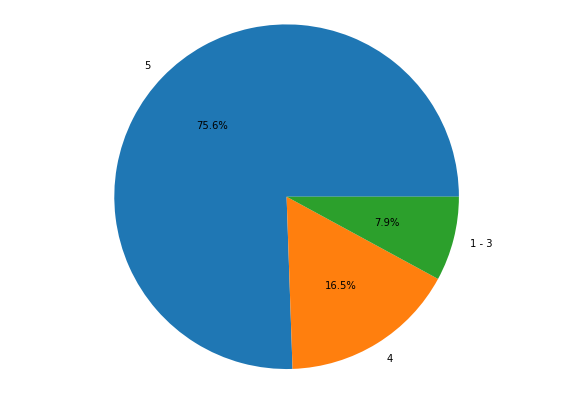

In [19]:
# 75.6% of learners have given a rating of 5

plt.figure(figsize =(10, 7)) 
plt.pie([6146, 1345, 644], labels = ['5', '4', '1 - 3'], autopct='%1.1f%%');
plt.axis('equal')
plt.show()

In [20]:
# Create column 'length' for number of characters in a review

df['length'] = df['review'].astype(str).apply(len)
df.head()

,date,review,rating,status,length
0,2021-03-11,This course has a good overview of data scienc...,5,completer,371
1,2021-03-11,Greate Course,5,completer,13
2,2021-03-10,have an overall understanding of data science ...,5,completer,70
3,2021-03-10,Course creates interest to keep on learning,4,completer,43
4,2021-03-10,Even though I have been self-teaching for abou...,5,completer,148


In [22]:
# The average length of a review is 96 characters - reviews are in general short

df['length'].describe()

count    8135.000000
mean       96.906822
std       118.937914
min         1.000000
25%        33.000000
50%        66.000000
75%       123.000000
max      3274.000000
Name: length, dtype: float64

In [24]:
# The longest reviews have a rating of 1. Shortest reviews genrally have a rating of 5. 

px.box(df, x = "rating", y = "length")

In [25]:
# Create new dataframe and remove reviews with less than three characters

df_clean = df[df['length'] > 2]

In [26]:
df_clean['length'].describe()

count    8095.000000
mean       97.379988
std       119.040321
min         3.000000
25%        33.000000
50%        67.000000
75%       123.000000
max      3274.000000
Name: length, dtype: float64

In [27]:
df_clean.shape

(8095, 5)

In [28]:
# Reset the index

df_clean = df_clean.reset_index(drop = True)

In [29]:
df_clean

,date,review,rating,status,length
0,2021-03-11,This course has a good overview of data scienc...,5,completer,371
1,2021-03-11,Greate Course,5,completer,13
2,2021-03-10,have an overall understanding of data science ...,5,completer,70
3,2021-03-10,Course creates interest to keep on learning,4,completer,43
4,2021-03-10,Even though I have been self-teaching for abou...,5,completer,148
...,...,...,...,...,...
8090,2018-08-28,Some very interesting materials in the form of...,5,dropout,72
8091,2018-08-28,Very easy to understand. A perfect introductio...,5,dropout,104
8092,2018-08-28,Muy buen curso para aprender fundamentos de Da...,5,dropout,57
8093,2018-08-25,"Was good learning spl, if you are looking to b...",5,completer,96


In [30]:
# Label reviews as positive, negative and neutral depending on their rating

label = []

for row in df_clean['rating']:
    if row == 1 or row == 2:
        label.append('neg')
    elif row == 3:
        label.append('neu')
    else:
        label.append('pos')

In [31]:
df_clean['label'] = label

In [32]:
df_clean.head()

,date,review,rating,status,length,label
0,2021-03-11,This course has a good overview of data scienc...,5,completer,371,pos
1,2021-03-11,Greate Course,5,completer,13,pos
2,2021-03-10,have an overall understanding of data science ...,5,completer,70,pos
3,2021-03-10,Course creates interest to keep on learning,4,completer,43,pos
4,2021-03-10,Even though I have been self-teaching for abou...,5,completer,148,pos


In [33]:
df_clean['label'].value_counts()

pos    7453
neu     341
neg     301
Name: label, dtype: int64

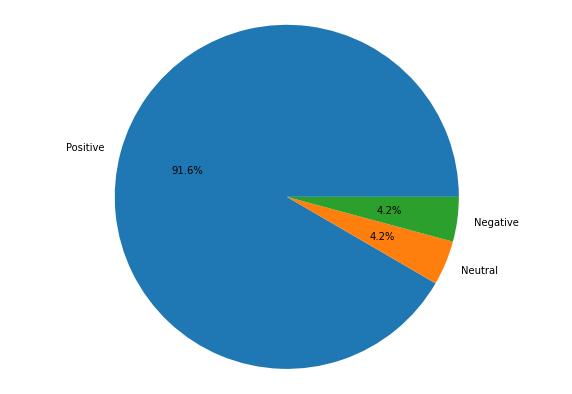

In [34]:
# 88 % of the reviews are positive according to the rating

plt.figure(figsize =(10, 7)) 
plt.pie([7453, 341, 341], labels = ['Positive', 'Neutral', 'Negative'], autopct='%1.1f%%');
plt.axis('equal')
plt.show()

In [35]:
# Removing reviews of languages other than English to improve the accuracy of the sentiment classifier

# Define the language detector using spacy

nlp = spacy.load('en_core_web_sm')
nlp.add_pipe(LanguageDetector(), name = 'language_detector', last = True)

In [36]:
# Detect language of reviews

language = []

for row in df_clean['review']:
    doc = nlp(row)
    language.append(doc._.language)


In [37]:
df_clean['language_scores'] = language

In [38]:
df_clean['language_scores']

0       {'language': 'en', 'score': 0.9999957253533018}
1        {'language': 'en', 'score': 0.999994475073214}
2       {'language': 'en', 'score': 0.9999964991174284}
3       {'language': 'en', 'score': 0.9999949953681738}
4       {'language': 'en', 'score': 0.9999963070938086}
                             ...                       
8090    {'language': 'en', 'score': 0.9999981815122434}
8091    {'language': 'en', 'score': 0.9999966849108909}
8092    {'language': 'es', 'score': 0.9999941655871919}
8093    {'language': 'en', 'score': 0.9999959884376415}
8094    {'language': 'en', 'score': 0.9999981457448335}
Name: language_scores, Length: 8095, dtype: object

In [39]:
df_clean['language']  = df_clean['language_scores'].apply(lambda score_dict: score_dict['language'])


In [40]:
df_clean['language'].value_counts()

en         7075
fr          211
es          141
so          117
ca          108
af           72
it           67
ro           64
pt           48
de           35
no           32
tl           18
da           18
nl           16
pl           14
sw           10
vi            9
cy            6
sq            5
id            5
sl            4
et            4
sv            3
fi            3
hr            2
lv            2
cs            2
UNKNOWN       2
zh-cn         1
hu            1
Name: language, dtype: int64

In [70]:
# We only want to keep reviews in English

df_clean[df_clean['language'] == 'sv']

,date,review,rating,status,length,label,language_scores,language
1356,2020-07-24,I had fun learning!,5,completer,19,pos,"{'language': 'sv', 'score': 0.5714266035237424}",sv
3068,2020-04-21,great kickstart,5,completer,15,pos,"{'language': 'sv', 'score': 0.9999959879814925}",sv
5618,2019-09-19,å ¥é¨å¯ä»¥éä¾¿çç,4,completer,24,pos,"{'language': 'sv', 'score': 0.9999981932139077}",sv


In [71]:
# After checking the language classifications we decide to remove reviews classified as 
# Spanish, Partugese, Danish, Swedish, Albanian, Finish, Chinese , Swedish and UNKNOWN

exclude = ['es','pt', 'da', 'sq', 'fi', 'UNKNOWN', 'zh-cn', 'sv']

In [72]:
# Remove the reviews with language in list exclude

df_clean = df_clean[~df_clean['language'].isin(exclude)]


In [73]:
df_clean

,date,review,rating,status,length,label,language_scores,language
0,2021-03-11,This course has a good overview of data scienc...,5,completer,371,pos,"{'language': 'en', 'score': 0.9999957253533018}",en
1,2021-03-11,Greate Course,5,completer,13,pos,"{'language': 'en', 'score': 0.999994475073214}",en
2,2021-03-10,have an overall understanding of data science ...,5,completer,70,pos,"{'language': 'en', 'score': 0.9999964991174284}",en
3,2021-03-10,Course creates interest to keep on learning,4,completer,43,pos,"{'language': 'en', 'score': 0.9999949953681738}",en
4,2021-03-10,Even though I have been self-teaching for abou...,5,completer,148,pos,"{'language': 'en', 'score': 0.9999963070938086}",en
...,...,...,...,...,...,...,...,...
8089,2018-08-28,Thanks for the data science introduction!,5,dropout,42,pos,"{'language': 'en', 'score': 0.9999962687011881}",en
8090,2018-08-28,Some very interesting materials in the form of...,5,dropout,72,pos,"{'language': 'en', 'score': 0.9999981815122434}",en
8091,2018-08-28,Very easy to understand. A perfect introductio...,5,dropout,104,pos,"{'language': 'en', 'score': 0.9999966849108909}",en
8093,2018-08-25,"Was good learning spl, if you are looking to b...",5,completer,96,pos,"{'language': 'en', 'score': 0.9999959884376415}",en


In [74]:
# Reset the index

df_clean = df_clean.reset_index(drop = True)

## VADER Sentiment analysis

Code reference: https://towardsdatascience.com/sentimental-analysis-using-vader-a3415fef7664

In [75]:
# Create a copy of the dataframe

df_vader = df_clean.copy(deep = True)

In [76]:
# Create the vader sentiment calculator 

sid = SentimentIntensityAnalyzer()

In [77]:
# Apply vader to the reviews

df_vader['scores'] = df_vader['review'].apply(lambda review: sid.polarity_scores(review))

df_vader.head()

,date,review,rating,status,length,label,language_scores,language,scores
0,2021-03-11,This course has a good overview of data scienc...,5,completer,371,pos,"{'language': 'en', 'score': 0.9999957253533018}",en,"{'neg': 0.0, 'neu': 0.803, 'pos': 0.197, 'comp..."
1,2021-03-11,Greate Course,5,completer,13,pos,"{'language': 'en', 'score': 0.999994475073214}",en,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
2,2021-03-10,have an overall understanding of data science ...,5,completer,70,pos,"{'language': 'en', 'score': 0.9999964991174284}",en,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
3,2021-03-10,Course creates interest to keep on learning,4,completer,43,pos,"{'language': 'en', 'score': 0.9999949953681738}",en,"{'neg': 0.0, 'neu': 0.495, 'pos': 0.505, 'comp..."
4,2021-03-10,Even though I have been self-teaching for abou...,5,completer,148,pos,"{'language': 'en', 'score': 0.9999963070938086}",en,"{'neg': 0.0, 'neu': 0.921, 'pos': 0.079, 'comp..."


In [78]:
# Extract the compound score from each review

df_vader['compound']  = df_vader['scores'].apply(lambda score_dict: score_dict['compound'])

df_vader.head()

,date,review,rating,status,length,label,language_scores,language,scores,compound
0,2021-03-11,This course has a good overview of data scienc...,5,completer,371,pos,"{'language': 'en', 'score': 0.9999957253533018}",en,"{'neg': 0.0, 'neu': 0.803, 'pos': 0.197, 'comp...",0.8999
1,2021-03-11,Greate Course,5,completer,13,pos,"{'language': 'en', 'score': 0.999994475073214}",en,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
2,2021-03-10,have an overall understanding of data science ...,5,completer,70,pos,"{'language': 'en', 'score': 0.9999964991174284}",en,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
3,2021-03-10,Course creates interest to keep on learning,4,completer,43,pos,"{'language': 'en', 'score': 0.9999949953681738}",en,"{'neg': 0.0, 'neu': 0.495, 'pos': 0.505, 'comp...",0.6249
4,2021-03-10,Even though I have been self-teaching for abou...,5,completer,148,pos,"{'language': 'en', 'score': 0.9999963070938086}",en,"{'neg': 0.0, 'neu': 0.921, 'pos': 0.079, 'comp...",0.2263


In [79]:
# We once again label reviews as positive, negative and neutral depending on their compound score

sentiment = []

for row in df_vader['compound']:
    if row < 0:
        sentiment.append('neg')
    elif row > 0:
        sentiment.append('pos')
    else:
        sentiment.append('neu')
        

In [80]:
df_vader['sentiment'] = sentiment

df_vader

,date,review,rating,status,length,label,language_scores,language,scores,compound,sentiment
0,2021-03-11,This course has a good overview of data scienc...,5,completer,371,pos,"{'language': 'en', 'score': 0.9999957253533018}",en,"{'neg': 0.0, 'neu': 0.803, 'pos': 0.197, 'comp...",0.8999,pos
1,2021-03-11,Greate Course,5,completer,13,pos,"{'language': 'en', 'score': 0.999994475073214}",en,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neu
2,2021-03-10,have an overall understanding of data science ...,5,completer,70,pos,"{'language': 'en', 'score': 0.9999964991174284}",en,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neu
3,2021-03-10,Course creates interest to keep on learning,4,completer,43,pos,"{'language': 'en', 'score': 0.9999949953681738}",en,"{'neg': 0.0, 'neu': 0.495, 'pos': 0.505, 'comp...",0.6249,pos
4,2021-03-10,Even though I have been self-teaching for abou...,5,completer,148,pos,"{'language': 'en', 'score': 0.9999963070938086}",en,"{'neg': 0.0, 'neu': 0.921, 'pos': 0.079, 'comp...",0.2263,pos
...,...,...,...,...,...,...,...,...,...,...,...
7869,2018-08-28,Thanks for the data science introduction!,5,dropout,42,pos,"{'language': 'en', 'score': 0.9999962687011881}",en,"{'neg': 0.0, 'neu': 0.61, 'pos': 0.39, 'compou...",0.4926,pos
7870,2018-08-28,Some very interesting materials in the form of...,5,dropout,72,pos,"{'language': 'en', 'score': 0.9999981815122434}",en,"{'neg': 0.0, 'neu': 0.639, 'pos': 0.361, 'comp...",0.6240,pos
7871,2018-08-28,Very easy to understand. A perfect introductio...,5,dropout,104,pos,"{'language': 'en', 'score': 0.9999966849108909}",en,"{'neg': 0.0, 'neu': 0.591, 'pos': 0.409, 'comp...",0.8655,pos
7872,2018-08-25,"Was good learning spl, if you are looking to b...",5,completer,96,pos,"{'language': 'en', 'score': 0.9999959884376415}",en,"{'neg': 0.0, 'neu': 0.847, 'pos': 0.153, 'comp...",0.4404,pos


In [82]:
# Using the rating as the measurement for comparison, VADER can classify the reviews correctly as pos/neg/neu with a 84% accuracy

print( 'The accuracy of the sentiment prediction is ', accuracy_score(df_vader.label, sentiment))

The accuracy of the sentiment prediction is  0.8479806959613919


In [83]:
# Save dataframe as a csv file

# df_vader.to_csv('VADER-what-is-data.csv')

## Data Visualization and Evaluation

Code reference: https://towardsdatascience.com/sentiment-analysis-on-amazon-reviews-45cd169447ac

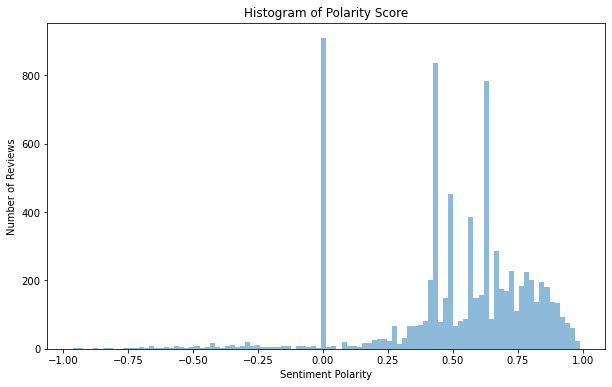

In [84]:
# Histogram of the compound polarity score

num_bins = 100
plt.figure(figsize = (10,6))
n, bins, patches = plt.hist(df_vader.compound, num_bins, alpha = 0.5)
plt.xlabel('Sentiment Polarity')
plt.ylabel('Number of Reviews')
plt.title('Histogram of Polarity Score')
plt.show();

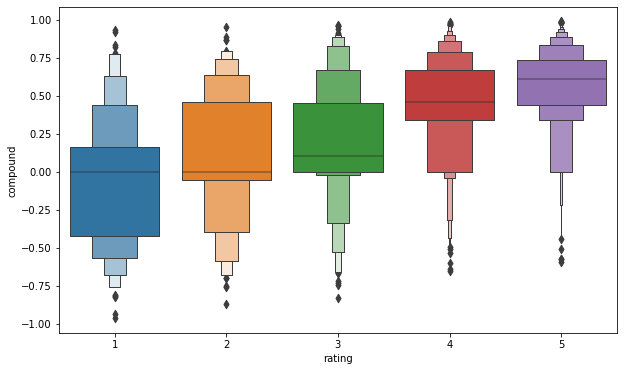

In [85]:
# There are some reviews with a positive sentiment that had a rating of 1 or 2

plt.figure(figsize = (10,6))
sns.boxenplot(x = 'rating', y = 'compound', data = df_vader)
plt.show();

In [86]:
# Reviewing reviews with a negative sentiment 
# it seems that some reviews have been rated incorrectly by the learner, but also that VADER
# has problems classifying the sentiment correctly

df_vader[(df_vader["sentiment"] == "neg")]

,date,review,rating,status,length,label,language_scores,language,scores,compound,sentiment
10,2021-03-09,Very basic and sometimes confusing,3,completer,35,neu,"{'language': 'en', 'score': 0.99999810471737}",en,"{'neg': 0.322, 'neu': 0.678, 'pos': 0.0, 'comp...",-0.2263,neg
86,2021-02-21,This course is overall very vague and too long...,1,completer,819,neg,"{'language': 'en', 'score': 0.9999987773183832}",en,"{'neg': 0.072, 'neu': 0.868, 'pos': 0.06, 'com...",-0.1972,neg
92,2021-02-21,the course explain every term as an introducto...,5,completer,167,pos,"{'language': 'en', 'score': 0.9999968279134472}",en,"{'neg': 0.054, 'neu': 0.946, 'pos': 0.0, 'comp...",-0.1531,neg
109,2021-02-18,This course is totally theoretical and no hand...,2,completer,204,neg,"{'language': 'en', 'score': 0.9999980209718604}",en,"{'neg': 0.145, 'neu': 0.855, 'pos': 0.0, 'comp...",-0.6030,neg
116,2021-02-16,it is suitable for people with absolutely no k...,3,completer,74,neu,"{'language': 'en', 'score': 0.9999938838859209}",en,"{'neg': 0.185, 'neu': 0.815, 'pos': 0.0, 'comp...",-0.3597,neg
...,...,...,...,...,...,...,...,...,...,...,...
7689,2018-10-05,"Don't take it. No Course Instructors, no help....",1,completer,139,neg,"{'language': 'en', 'score': 0.9999967135966012}",en,"{'neg': 0.225, 'neu': 0.617, 'pos': 0.157, 'co...",-0.2448,neg
7711,2018-10-01,Utter waste of time,1,completer,19,neg,"{'language': 'en', 'score': 0.999997031316422}",en,"{'neg': 0.483, 'neu': 0.517, 'pos': 0.0, 'comp...",-0.4215,neg
7778,2018-09-16,I liked the videos from not only professors bu...,5,dropout,507,pos,"{'language': 'en', 'score': 0.9999957222453183}",en,"{'neg': 0.081, 'neu': 0.855, 'pos': 0.064, 'co...",-0.3634,neg
7785,2018-09-14,Too repetitive. You could probably just pick 2...,2,completer,107,neg,"{'language': 'en', 'score': 0.9999971859210103}",en,"{'neg': 0.105, 'neu': 0.895, 'pos': 0.0, 'comp...",-0.2500,neg


In [87]:
# Creating a dataframe for the reviews with a negative sentiment

neg_reviews = df_vader[(df_vader["sentiment"] == "neg")]

In [88]:
# Negative reviews only classified with a 36% accuracy using the rating as the measurement
# This number is very low

print( 'The accuracy of the negative sentiment prediction is ', accuracy_score(neg_reviews.label, neg_reviews.sentiment))

The accuracy of the negative sentiment prediction is  0.4567901234567901


In [89]:
# Dataframe with reviews with a negative rating

neg_label = df_vader[(df_vader["label"] == "neg")]

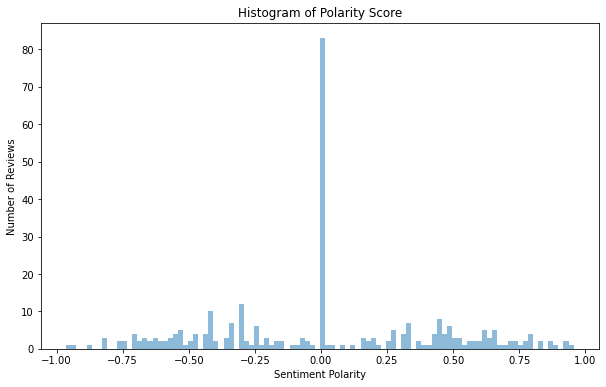

In [90]:
# Histogram of the compound polarity score of of reviews with a negative rating

num_bins = 100
plt.figure(figsize = (10,6))
n, bins, patches = plt.hist(neg_label.compound, num_bins, alpha = 0.5)
plt.xlabel('Sentiment Polarity')
plt.ylabel('Number of Reviews')
plt.title('Histogram of Polarity Score')
plt.show();

In [91]:
# Reviewing reviews with a positive sentiment 

df_vader[(df_vader["sentiment"] == "pos")]

,date,review,rating,status,length,label,language_scores,language,scores,compound,sentiment
0,2021-03-11,This course has a good overview of data scienc...,5,completer,371,pos,"{'language': 'en', 'score': 0.9999957253533018}",en,"{'neg': 0.0, 'neu': 0.803, 'pos': 0.197, 'comp...",0.8999,pos
3,2021-03-10,Course creates interest to keep on learning,4,completer,43,pos,"{'language': 'en', 'score': 0.9999949953681738}",en,"{'neg': 0.0, 'neu': 0.495, 'pos': 0.505, 'comp...",0.6249,pos
4,2021-03-10,Even though I have been self-teaching for abou...,5,completer,148,pos,"{'language': 'en', 'score': 0.9999963070938086}",en,"{'neg': 0.0, 'neu': 0.921, 'pos': 0.079, 'comp...",0.2263,pos
5,2021-03-10,Good intro,5,completer,10,pos,"{'language': 'en', 'score': 0.9999938195647258}",en,"{'neg': 0.0, 'neu': 0.256, 'pos': 0.744, 'comp...",0.4404,pos
6,2021-03-09,Good introduction,4,completer,17,pos,"{'language': 'en', 'score': 0.9999961296918722}",en,"{'neg': 0.0, 'neu': 0.256, 'pos': 0.744, 'comp...",0.4404,pos
...,...,...,...,...,...,...,...,...,...,...,...
7869,2018-08-28,Thanks for the data science introduction!,5,dropout,42,pos,"{'language': 'en', 'score': 0.9999962687011881}",en,"{'neg': 0.0, 'neu': 0.61, 'pos': 0.39, 'compou...",0.4926,pos
7870,2018-08-28,Some very interesting materials in the form of...,5,dropout,72,pos,"{'language': 'en', 'score': 0.9999981815122434}",en,"{'neg': 0.0, 'neu': 0.639, 'pos': 0.361, 'comp...",0.6240,pos
7871,2018-08-28,Very easy to understand. A perfect introductio...,5,dropout,104,pos,"{'language': 'en', 'score': 0.9999966849108909}",en,"{'neg': 0.0, 'neu': 0.591, 'pos': 0.409, 'comp...",0.8655,pos
7872,2018-08-25,"Was good learning spl, if you are looking to b...",5,completer,96,pos,"{'language': 'en', 'score': 0.9999959884376415}",en,"{'neg': 0.0, 'neu': 0.847, 'pos': 0.153, 'comp...",0.4404,pos


In [92]:
# Creating a dataframe for the reviews with a positive sentiment

pos_reviews = df_vader[(df_vader["sentiment"] == "pos")]

In [93]:
# Positive reviews are classified with a 92% accuracy using the rating as the measurement

print( 'The accuracy of the positive sentiment prediction is ', accuracy_score(pos_reviews.label, pos_reviews.sentiment))

The accuracy of the positive sentiment prediction is  0.9585191793041927


In [94]:
# Dataframe with reviews with a positive rating

pos_label = df_vader[(df_vader["label"] == "pos")]

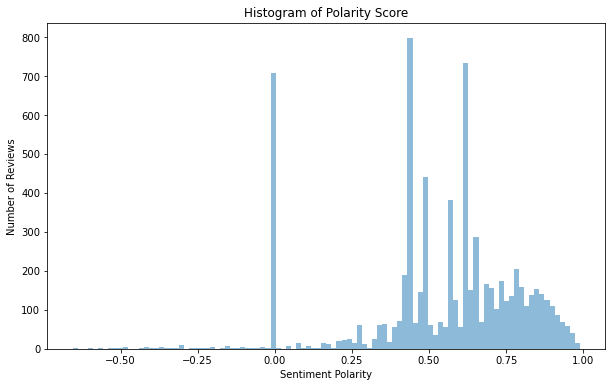

In [95]:
# Histogram of the compound polarity score of reviews with a positive rating

num_bins = 100
plt.figure(figsize = (10,6))
n, bins, patches = plt.hist(pos_label.compound, num_bins, alpha = 0.5)
plt.xlabel('Sentiment Polarity')
plt.ylabel('Number of Reviews')
plt.title('Histogram of Polarity Score')
plt.show();

In [96]:
# Reviewing reviews with a neutral sentiment  

df_vader[(df_vader["sentiment"] == "neu")]

,date,review,rating,status,length,label,language_scores,language,scores,compound,sentiment
1,2021-03-11,Greate Course,5,completer,13,pos,"{'language': 'en', 'score': 0.999994475073214}",en,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0,neu
2,2021-03-10,have an overall understanding of data science ...,5,completer,70,pos,"{'language': 'en', 'score': 0.9999964991174284}",en,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0,neu
27,2021-03-04,payment,1,completer,8,neg,"{'language': 'fr', 'score': 0.9999959725166991}",fr,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0,neu
28,2021-03-04,This course defines a data and data scientist ...,5,completer,112,pos,"{'language': 'en', 'score': 0.999997045390283}",en,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0,neu
36,2021-03-03,You can find what is data science and how you ...,4,completer,54,pos,"{'language': 'en', 'score': 0.9999974127519913}",en,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0,neu
...,...,...,...,...,...,...,...,...,...,...,...
7832,2018-09-05,Taught me basics in what Data Science is befor...,5,completer,100,pos,"{'language': 'en', 'score': 0.9999977887181879}",en,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0,neu
7848,2018-09-02,need to add some practical session using some ...,4,completer,62,pos,"{'language': 'en', 'score': 0.9999966177001732}",en,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0,neu
7856,2018-08-31,reeeeeealllly reallly basic. I was expecting a...,3,completer,64,neu,"{'language': 'en', 'score': 0.9999982613032635}",en,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0,neu
7857,2018-08-31,Very InformativeYou'll learn all the basics.,5,completer,44,pos,"{'language': 'en', 'score': 0.9999976797203707}",en,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0,neu


In [97]:
# Creating a dataframe for the reviews with a neutral sentiment

neu_reviews = df_vader[(df_vader["sentiment"] == "neu")]

In [98]:
# Neutral reviews are classified with a 13% accuracy using the rating as the measurement
# This number is very low

print( 'The accuracy of the positive sentiment prediction is ', accuracy_score(neu_reviews.label, neu_reviews.sentiment))


The accuracy of the positive sentiment prediction is  0.13149171270718232


In [99]:
# Creating dataframe for reviews with a neutral rating

neu_label = df_vader[(df_vader["label"] == "neu")]

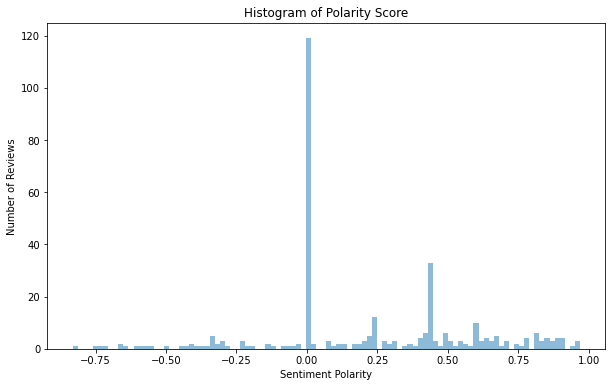

In [100]:
# Histogram of the compound polarity score of reviews with a neutral rating

num_bins = 100
plt.figure(figsize = (10,6))
n, bins, patches = plt.hist(neu_label.compound, num_bins, alpha = 0.5)
plt.xlabel('Sentiment Polarity')
plt.ylabel('Number of Reviews')
plt.title('Histogram of Polarity Score')
plt.show();